<h1> <center> JPMC CCB Risk Modelling Mentorship </center> </h1>
<h3> <center> Case Study | Unnati Singh </center> </h3>

<h3>1. Imports, Data Reading and Feature Engineering</h3>

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler

In [130]:
# Read the loan dataset from a CSV file, using 'latin1' encoding due to potential special characters
df = pd.read_csv("loan_dataset_final.csv", encoding='latin1')

# Drop columns that are not needed for analysis
df = df.drop(['emp_title', 'title', 'desc',
             'collections_12_mths_ex_med'], axis=1)

# Replace textual employment length categories with numerical values
df = df.replace(['1 year', '6 years', '9 years', '< 1 year', '8 years', '10+ years', '5 years', '2 years', '3 years', '4 years', '7 years'],
                [1, 6, 9, 0, 8, 10, 5, 2, 3, 4, 7])

# Fill missing values in 'emp_length' with 0
df['emp_length'] = df['emp_length'].fillna(0)

# Fill missing values in 'annual_inc' with the mean of the column
df['annual_inc'] = df['annual_inc'].fillna(df['annual_inc'].mean())

# Calculate a ratio 'Division' and use it to fill missing values in 'lti', then drop 'Division'
df['Division'] = df['loan_amnt'] / df['annual_inc']
df['lti'] = df['lti'].fillna(df['Division'])
df = df.drop(columns=['Division'])

# Fill missing values in several columns with specific strategies
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(
    df['mths_since_last_delinq'].max()*5)

df['mths_since_last_record'] = df['mths_since_last_record'].fillna(
    df['mths_since_last_record'].max()*5)

df['month_since_oldest_tl'] = df['month_since_oldest_tl'].fillna(
    df['month_since_oldest_tl'].max()*5)

df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(0)
df['inq_last_6mths'] = df['inq_last_6mths'].fillna(0)
df['open_acc'] = df['open_acc'].fillna(0)
df['pub_rec'] = df['pub_rec'].fillna(0)
df['total_acc'] = df['total_acc'].fillna(0)
df['revol_utilization'] = df['revol_utilization'].fillna(0)

C:\Users\unnat\AppData\Local\Temp\ipykernel_32700\1409331439.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['1 year', '6 years', '9 years', '< 1 year', '8 years', '10+ years', '5 years', '2 years', '3 years', '4 years', '7 years'],


In [131]:
_, test_output = train_test_split(df, test_size=0.1, random_state=26) # for writing out the output of the model

In [132]:
test_output[' '] = ' '

test_output

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,...,pub_rec_bankruptcies,interest_rate,revol_utilization,number_bc_gt_75,fico_score,lti,month_since_oldest_tl,race_name,gender,
28054,774533,976716,2500,2500,2500.00000,36 months,76.05,2.0,MORTGAGE,65000.0,...,0.0,0.0599,0.1290,0,744,0.038462,198.0,White,Male,
28545,784938,988195,10000,10000,10000.00000,36 months,304.18,0.0,RENT,33000.0,...,0.0,0.0599,0.0080,0,799,0.303030,127.0,Asian,Female,
12,1000242,1225464,15000,15000,14975.00000,60 months,389.36,10.0,MORTGAGE,86945.0,...,1.0,0.1903,0.7290,1,699,0.172523,108.0,Asian,Male,
4132,219479,219422,7500,7500,4650.00000,36 months,265.39,4.0,RENT,45000.0,...,0.0,0.1646,0.8980,2,679,0.166667,137.0,African American,Male,
32175,855069,1067368,9200,9200,8925.00000,60 months,209.29,2.0,RENT,31000.0,...,0.0,0.1299,0.0990,0,724,0.296774,46.0,Other,Male,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8125,431130,511576,3000,3000,2950.00000,36 months,98.59,5.0,MORTGAGE,65200.0,...,0.0,0.1126,0.5810,1,704,0.046012,89.0,Asian,Male,
8267,433469,516370,18500,18500,18109.40272,36 months,622.22,3.0,RENT,145000.0,...,0.0,0.1287,0.5330,1,714,0.127586,134.0,Asian,Male,
26093,736534,933494,4000,4000,4000.00000,36 months,137.77,1.0,RENT,35000.0,...,0.0,0.1454,0.7690,1,704,0.114286,51.0,Other,Female,
126,1002568,1228613,25000,25000,24900.00000,60 months,564.87,5.0,MORTGAGE,184000.0,...,0.0,0.1269,0.1780,0,769,0.135870,126.0,White,Female,


In [133]:
# Filtering columns from the original dataframe
output_columns = df[['funded_amnt', 'funded_amnt_inv', 'issue_d', 'loan_status', 'pymnt_plan', 'out_prncp', 'out_prncp_inv',
                     'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
                     'collection_recovery_fee', 'interest_rate', 'installment']]

df = df.drop(output_columns.columns, axis=1)
df.head()

,id,member_id,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,...,revol_bal,total_acc,pub_rec_bankruptcies,revol_utilization,number_bc_gt_75,fico_score,lti,month_since_oldest_tl,race_name,gender
0,1000007,1225615,5150,60 months,1.0,RENT,34992.0,Source Verified,debt_consolidation,NY,...,15187,21.0,1.0,0.873,2,709,0.147176,124.0,White,Female
1,1000030,1225638,20000,36 months,6.0,RENT,72000.0,Verified,moving,NY,...,15637,14.0,0.0,0.354,0,744,0.277778,149.0,African American,Female
2,1000033,1225642,12800,60 months,9.0,MORTGAGE,81708.0,Source Verified,home_improvement,TX,...,905,23.0,0.0,0.754,0,719,0.156655,176.0,White,Female
3,1000045,1225655,14000,60 months,9.0,MORTGAGE,72000.0,Verified,debt_consolidation,GA,...,9218,39.0,0.0,0.357,0,714,0.194444,140.0,White,Female
4,1000067,1225680,15000,60 months,0.0,RENT,72000.0,Verified,small_business,AL,...,10891,30.0,0.0,0.369,0,709,0.208333,136.0,White,Female


In [134]:
# Calculating the total amount to be paid based on principal and interest rate
output_columns['total_amnt_to_be_paid'] = output_columns['installment']*df.replace(['36 months', '60 months'], [36, 60], inplace=False)['term']

C:\Users\unnat\AppData\Local\Temp\ipykernel_32700\3638473426.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  output_columns['total_amnt_to_be_paid'] = output_columns['installment']*df.replace(['36 months', '60 months'], [36, 60], inplace=False)['term']


In [135]:
output_columns.head()

,funded_amnt,funded_amnt_inv,issue_d,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,interest_rate,installment,total_amnt_to_be_paid
0,5150,5150.0,Nov-11,Current,n,266.22,266.22,7674.25000,7674.25,4883.78,2790.47,0.0,0.0,0.0,0.1864,132.58,7954.80
1,20000,20000.0,Oct-11,Fully Paid,n,0.00,0.00,22610.98773,22610.99,20000.00,2610.99,0.0,0.0,0.0,0.0890,635.07,22862.52
2,12800,12750.0,Nov-11,Fully Paid,n,0.00,0.00,14401.17047,14344.92,12800.00,1601.17,0.0,0.0,0.0,0.1677,316.54,18992.40
3,14000,14000.0,Oct-11,Fully Paid,n,0.00,0.00,14793.06399,14793.06,14000.00,793.06,0.0,0.0,0.0,0.1727,349.98,20998.80
4,15000,14975.0,Nov-11,Current,n,754.69,753.37,21457.45000,21421.81,14245.32,7212.13,0.0,0.0,0.0,0.1677,370.94,22256.40


In [136]:
# total number of unique values present in each column
for column in output_columns.columns:
    print(f'{column}: {len(output_columns[column].unique())}')

funded_amnt: 1051
funded_amnt_inv: 9240
issue_d: 55
loan_status: 9
pymnt_plan: 2
out_prncp: 547
out_prncp_inv: 548
total_pymnt: 40579
total_pymnt_inv: 40108
total_rec_prncp: 8214
total_rec_int: 37533
total_rec_late_fee: 1562
recoveries: 4530
collection_recovery_fee: 2857
interest_rate: 394
installment: 16459
total_amnt_to_be_paid: 17341


In [137]:
# Extracting sensitive columns from the original dataframe
sensitive = df[['gender', 'race_name', 'addr_state']]
sensitive.head()

,gender,race_name,addr_state
0,Female,White,NY
1,Female,African American,NY
2,Female,White,TX
3,Female,White,GA
4,Female,White,AL


In [138]:
# (output_columns['recoveries'] > 0 & output_columns['loan_status'] != 'Default')

# Preparing conditions for filtering data
condition1 = output_columns['recoveries'] > 0
condition2 = output_columns['loan_status'] != 'Charged Off'
condition3 = output_columns['loan_status'] != 'Does not meet the credit policy. Status:Charged Off'

condition = condition2 & condition3

combined_condition = condition1 & condition

In [139]:
combined_condition.sum()

0

In [140]:
# Generating numerical categories for loan status 
output_columns = output_columns.replace(['Current', 'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Charged Off', 'In Grace Period', 
                 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default'],
                 [2, 0, 1, 8, 3, 5, 4, 6, 7])

C:\Users\unnat\AppData\Local\Temp\ipykernel_32700\744867313.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  output_columns = output_columns.replace(['Current', 'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Charged Off', 'In Grace Period',


<h3>2. Classification of Customers into 'Good' and 'Bad'</h3>

<h4>Engineering Features</h4>
<ul> 
<li>r1 := Late fee averaged over time emulated by a ratio of total late fee and total payable amount</li>
<li>r2 := Ratio of recoveries and total payment</li>
<li>r3 := Ratio of interest and principal : A high interest rate suggests that the customer was already considered risky</li>
<li>r4 := Ratio of amount funded by the investors out of the total amount : Indicates the high trust level of investors on the customer</li>
</ul>

In [141]:
# r1
output_columns['r1'] = (output_columns['total_rec_late_fee'] * output_columns['total_amnt_to_be_paid'])/ output_columns['total_pymnt']

# r2 
output_columns['r2'] = output_columns['recoveries'] / output_columns['total_pymnt']

# r3

output_columns['r3'] = output_columns['total_rec_int'] / output_columns['total_rec_prncp']

# r4 

output_columns['r4'] = output_columns['funded_amnt_inv'] / output_columns['funded_amnt']

# Getting rid of NaN and inf values
output_columns['r1'] = output_columns['r1'].replace([np.inf, -np.inf], np.nan)
max_value = output_columns['r1'].max()
output_columns['r1'] = output_columns['r1'].fillna(20)

output_columns['r2'] = output_columns['r2'].replace([np.inf, -np.inf], np.nan)
max_value = output_columns['r2'].max()
output_columns['r2'] = output_columns['r2'].fillna(max_value*5)

output_columns['r3'] = output_columns['r3'].replace([np.inf, -np.inf], np.nan)
output_columns['r3'] = output_columns['r3'].fillna(0)

output_columns['r4'] = output_columns['r4'].replace([np.inf, -np.inf], np.nan)
output_columns['r4'] = output_columns['r4'].fillna(0)

# Saving the engineered dataframe into excel
# output_columns.to_excel('output.xlsx')

output_columns.head()

,funded_amnt,funded_amnt_inv,issue_d,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,total_rec_late_fee,recoveries,collection_recovery_fee,interest_rate,installment,total_amnt_to_be_paid,r1,r2,r3,r4
0,5150,5150.0,Nov-11,2,n,266.22,266.22,7674.25000,7674.25,4883.78,...,0.0,0.0,0.0,0.1864,132.58,7954.80,0.0,0.0,0.571375,1.000000
1,20000,20000.0,Oct-11,0,n,0.00,0.00,22610.98773,22610.99,20000.00,...,0.0,0.0,0.0,0.0890,635.07,22862.52,0.0,0.0,0.130549,1.000000
2,12800,12750.0,Nov-11,0,n,0.00,0.00,14401.17047,14344.92,12800.00,...,0.0,0.0,0.0,0.1677,316.54,18992.40,0.0,0.0,0.125091,0.996094
3,14000,14000.0,Oct-11,0,n,0.00,0.00,14793.06399,14793.06,14000.00,...,0.0,0.0,0.0,0.1727,349.98,20998.80,0.0,0.0,0.056647,1.000000
4,15000,14975.0,Nov-11,2,n,754.69,753.37,21457.45000,21421.81,14245.32,...,0.0,0.0,0.0,0.1677,370.94,22256.40,0.0,0.0,0.506281,0.998333


<h4>Data Visualisation</h4>

Text(0.5, 0, 'Loan Status')

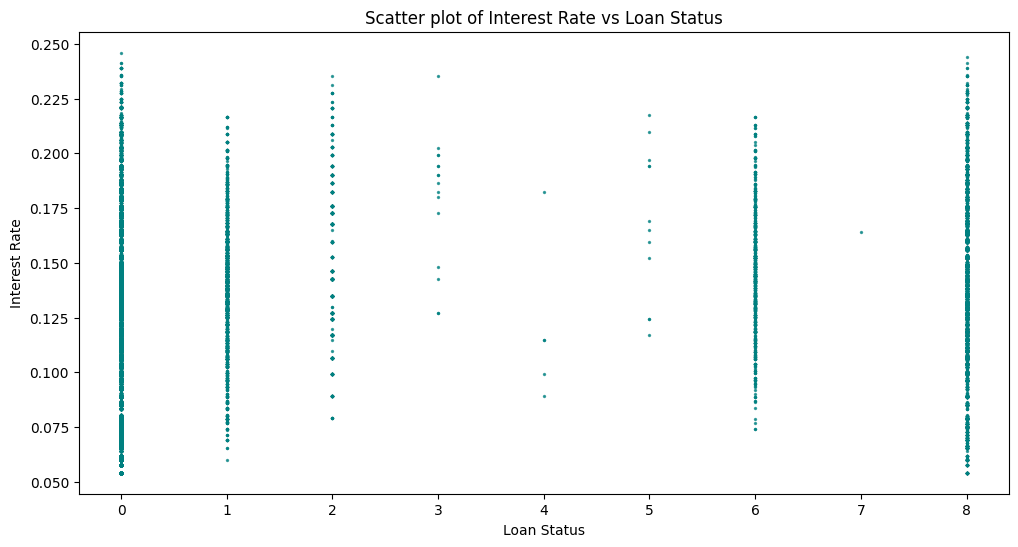

In [142]:
plt.figure(figsize=(12, 6), dpi = 100)

# Plot for Interest Rate (used in lieu of r3) vs. Loan Status
# plt.subplot(1, 2, 1)
plt.title('Scatter plot of Interest Rate vs Loan Status')
plt.scatter(y=output_columns['interest_rate'], x=output_columns['loan_status'], s=2, color='teal', alpha=0.7)
plt.ylabel("Interest Rate")
plt.xlabel('Loan Status')

Text(0.5, 0, 'Loan Status')

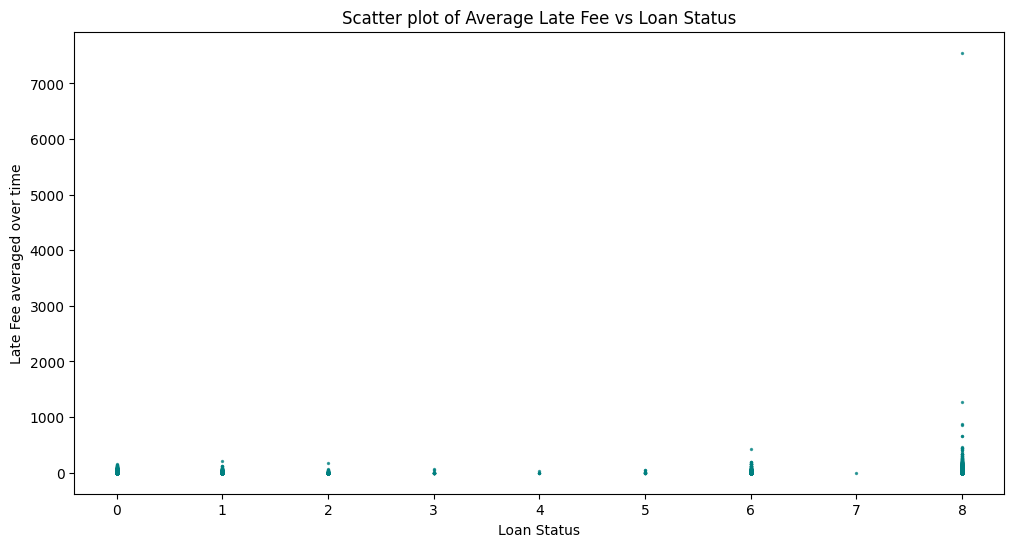

In [143]:
# Plot between r1 (time average of late fee) and loan status
plt.figure(figsize=(12, 6), dpi = 100)
plt.title('Scatter plot of Average Late Fee vs Loan Status')
plt.scatter(y=output_columns['r1'], x=output_columns['loan_status'], s=2, color='teal', alpha=0.7)
plt.ylabel("Late Fee averaged over time")
plt.xlabel('Loan Status')

Text(0.5, 0, 'Loan Status')

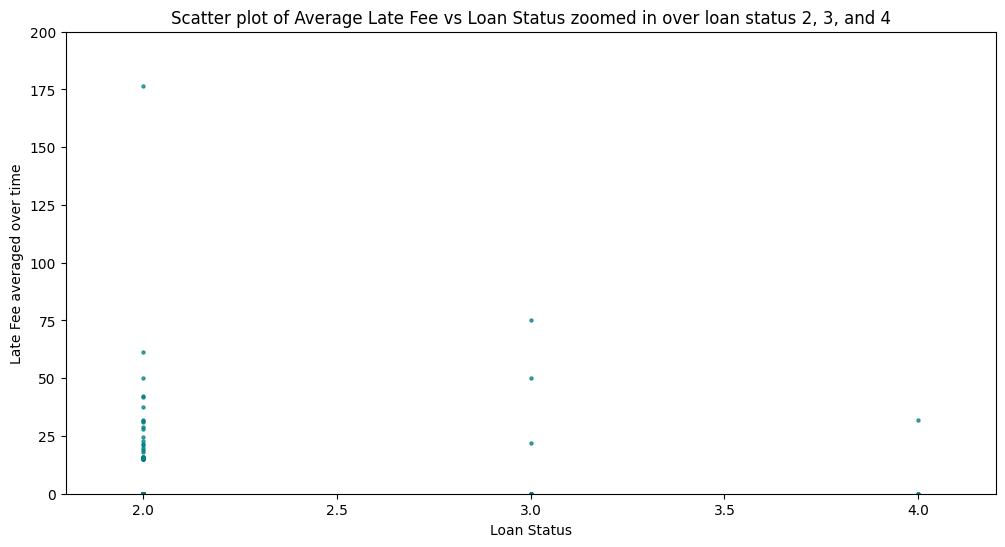

In [144]:
# Closer observation on loan status = {2, 3, 4} for more detailed analysis of good and bad customers
plt.figure(figsize=(12, 6), dpi = 100)
plt.title('Scatter plot of Average Late Fee vs Loan Status zoomed in over loan status 2, 3, and 4')
plt.scatter(y=output_columns['r1'], x=output_columns['loan_status'], s=5, color='teal', alpha=0.7)
plt.xlim(1.8, 4.2)
plt.ylim(0, 200)
plt.ylabel("Late Fee averaged over time")
plt.xlabel('Loan Status')

#### ANOVA Test

Perform a one-way ANOVA test on different r values to determine if there are statistically significant differences
between the means of different 'loan_status' groups

In [145]:
anova_result_int = stats.f_oneway(*[output_columns['interest_rate'][output_columns['loan_status'] == status] 
                                for status in output_columns['loan_status'].unique()])
print(f"Anova result on Interest Rate: {anova_result_int}")

anova_result_r1 = stats.f_oneway(*[output_columns['r1'][output_columns['loan_status'] == status] 
                                for status in output_columns['loan_status'].unique()])
print(f"Anova result on r1: {anova_result_r1}")

anova_result_r2 = stats.f_oneway(*[output_columns['r3'][output_columns['loan_status'] == status]
                              for status in output_columns['loan_status'].unique()])
print(f"Anova result on r2: {anova_result_r2}")

anova_result_r3 = stats.f_oneway(*[output_columns['r3'][output_columns['loan_status'] == status]
                              for status in output_columns['loan_status'].unique()])
print(f"Anova result on r3: {anova_result_r3}")

anova_result_r4 = stats.f_oneway(*[output_columns['r4'][output_columns['loan_status'] == status]
                              for status in output_columns['loan_status'].unique()])
print(f"Anova result on r4: {anova_result_r4}")

Anova result on Interest Rate: F_onewayResult(statistic=397.95058781531685, pvalue=0.0)
Anova result on r1: F_onewayResult(statistic=59.16286005328915, pvalue=1.3387779463749574e-96)
Anova result on r2: F_onewayResult(statistic=2832.506815937986, pvalue=0.0)
Anova result on r3: F_onewayResult(statistic=2832.506815937986, pvalue=0.0)
Anova result on r4: F_onewayResult(statistic=648.6172378495689, pvalue=0.0)


Given the very low p-value, we can reject the null hypothesis that all group means are equal. This means that there are statistically significant differences between the means of the different groups.

The results indicate a significant difference between the categories of loan status.

# Getting Output Variable

In [146]:
df.head()

,id,member_id,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,...,revol_bal,total_acc,pub_rec_bankruptcies,revol_utilization,number_bc_gt_75,fico_score,lti,month_since_oldest_tl,race_name,gender
0,1000007,1225615,5150,60 months,1.0,RENT,34992.0,Source Verified,debt_consolidation,NY,...,15187,21.0,1.0,0.873,2,709,0.147176,124.0,White,Female
1,1000030,1225638,20000,36 months,6.0,RENT,72000.0,Verified,moving,NY,...,15637,14.0,0.0,0.354,0,744,0.277778,149.0,African American,Female
2,1000033,1225642,12800,60 months,9.0,MORTGAGE,81708.0,Source Verified,home_improvement,TX,...,905,23.0,0.0,0.754,0,719,0.156655,176.0,White,Female
3,1000045,1225655,14000,60 months,9.0,MORTGAGE,72000.0,Verified,debt_consolidation,GA,...,9218,39.0,0.0,0.357,0,714,0.194444,140.0,White,Female
4,1000067,1225680,15000,60 months,0.0,RENT,72000.0,Verified,small_business,AL,...,10891,30.0,0.0,0.369,0,709,0.208333,136.0,White,Female


In [147]:
output_columns.head()

,funded_amnt,funded_amnt_inv,issue_d,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,total_rec_late_fee,recoveries,collection_recovery_fee,interest_rate,installment,total_amnt_to_be_paid,r1,r2,r3,r4
0,5150,5150.0,Nov-11,2,n,266.22,266.22,7674.25000,7674.25,4883.78,...,0.0,0.0,0.0,0.1864,132.58,7954.80,0.0,0.0,0.571375,1.000000
1,20000,20000.0,Oct-11,0,n,0.00,0.00,22610.98773,22610.99,20000.00,...,0.0,0.0,0.0,0.0890,635.07,22862.52,0.0,0.0,0.130549,1.000000
2,12800,12750.0,Nov-11,0,n,0.00,0.00,14401.17047,14344.92,12800.00,...,0.0,0.0,0.0,0.1677,316.54,18992.40,0.0,0.0,0.125091,0.996094
3,14000,14000.0,Oct-11,0,n,0.00,0.00,14793.06399,14793.06,14000.00,...,0.0,0.0,0.0,0.1727,349.98,20998.80,0.0,0.0,0.056647,1.000000
4,15000,14975.0,Nov-11,2,n,754.69,753.37,21457.45000,21421.81,14245.32,...,0.0,0.0,0.0,0.1677,370.94,22256.40,0.0,0.0,0.506281,0.998333


<h4> </h4>

#### Classification of customers into Good and Bad based on different thresholds
It is advisable to have different thresholds for categorizing the customers into Good and Bad. The thresholds should depend on the loan status. The worse the loan status, the higher the threshold for being a 'Good' customer

In [148]:
# Initialize the column with default value 0
output_columns['int_out'] = 0

# Iterate through the DataFrame index 
for i in output_columns.index:
    if output_columns.loc[i, 'loan_status'] < 2: 
        output_columns.loc[i, 'int_out'] = 1

    elif output_columns.loc[i, 'loan_status'] == 2:
        if output_columns.loc[i, 'interest_rate'] < 0.25:
            output_columns.loc[i, 'int_out'] = 1
        
    elif output_columns.loc[i, 'loan_status'] == 3:
        if output_columns.loc[i, 'interest_rate'] < 0.175:
            output_columns.loc[i, 'int_out'] = 1
    
    elif output_columns.loc[i, 'loan_status'] == 4:
        if output_columns.loc[i, 'interest_rate'] < 0.15:
            output_columns.loc[i, 'r1_out'] = 1


output_columns.head()

,funded_amnt,funded_amnt_inv,issue_d,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,collection_recovery_fee,interest_rate,installment,total_amnt_to_be_paid,r1,r2,r3,r4,int_out,r1_out
0,5150,5150.0,Nov-11,2,n,266.22,266.22,7674.25000,7674.25,4883.78,...,0.0,0.1864,132.58,7954.80,0.0,0.0,0.571375,1.000000,1,NaN
1,20000,20000.0,Oct-11,0,n,0.00,0.00,22610.98773,22610.99,20000.00,...,0.0,0.0890,635.07,22862.52,0.0,0.0,0.130549,1.000000,1,NaN
2,12800,12750.0,Nov-11,0,n,0.00,0.00,14401.17047,14344.92,12800.00,...,0.0,0.1677,316.54,18992.40,0.0,0.0,0.125091,0.996094,1,NaN
3,14000,14000.0,Oct-11,0,n,0.00,0.00,14793.06399,14793.06,14000.00,...,0.0,0.1727,349.98,20998.80,0.0,0.0,0.056647,1.000000,1,NaN
4,15000,14975.0,Nov-11,2,n,754.69,753.37,21457.45000,21421.81,14245.32,...,0.0,0.1677,370.94,22256.40,0.0,0.0,0.506281,0.998333,1,NaN


In [149]:
# Initialize the column with default value 0
output_columns['r1_out'] = 0

# Iterate through the DataFrame index
for i in output_columns.index:
    if output_columns.loc[i, 'loan_status'] < 2: 
        output_columns.loc[i, 'r1_out'] = 1

    elif output_columns.loc[i, 'loan_status'] == 2:
        if output_columns.loc[i, 'r1'] < 100:
            output_columns.loc[i, 'r1_out'] = 1
        else:
            output_columns.loc[i, 'r1_out'] = 0

    elif output_columns.loc[i, 'loan_status'] == 3:
        if output_columns.loc[i, 'r1'] < 75:
            output_columns.loc[i, 'r1_out'] = 1
        else:
            output_columns.loc[i, 'r1_out'] = 0

    elif output_columns.loc[i, 'loan_status'] == 4:
        if output_columns.loc[i, 'r1'] < 50:
            output_columns.loc[i, 'r1_out'] = 1
        else:
            output_columns.loc[i, 'r1_out'] = 0

    else: 
        output_columns.loc[i, 'r1_out'] = 0

# Display the first few rows of the updated DataFrame
output_columns.head()

,funded_amnt,funded_amnt_inv,issue_d,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,collection_recovery_fee,interest_rate,installment,total_amnt_to_be_paid,r1,r2,r3,r4,int_out,r1_out
0,5150,5150.0,Nov-11,2,n,266.22,266.22,7674.25000,7674.25,4883.78,...,0.0,0.1864,132.58,7954.80,0.0,0.0,0.571375,1.000000,1,1
1,20000,20000.0,Oct-11,0,n,0.00,0.00,22610.98773,22610.99,20000.00,...,0.0,0.0890,635.07,22862.52,0.0,0.0,0.130549,1.000000,1,1
2,12800,12750.0,Nov-11,0,n,0.00,0.00,14401.17047,14344.92,12800.00,...,0.0,0.1677,316.54,18992.40,0.0,0.0,0.125091,0.996094,1,1
3,14000,14000.0,Oct-11,0,n,0.00,0.00,14793.06399,14793.06,14000.00,...,0.0,0.1727,349.98,20998.80,0.0,0.0,0.056647,1.000000,1,1
4,15000,14975.0,Nov-11,2,n,754.69,753.37,21457.45000,21421.81,14245.32,...,0.0,0.1677,370.94,22256.40,0.0,0.0,0.506281,0.998333,1,1


In [150]:
# Initialize the column with default value 0
output_columns['r4_out'] = 0

# Iterate through the DataFrame index
for i in output_columns.index:
    if output_columns.loc[i, 'loan_status'] < 2: 
        output_columns.loc[i, 'r4_out'] = 1

    elif output_columns.loc[i, 'loan_status'] == 2:
        if output_columns.loc[i, 'r4'] > 0.6:
            output_columns.loc[i, 'r4_out'] = 1
        # else:
        #     output_columns.loc[i, 'r4_out'] = 1

    elif output_columns.loc[i, 'loan_status'] < 5:
        output_columns.loc[i, 'r4_out'] = 1
    
    # else: 
    #     output_columns.loc[i, 'r4_out'] = 0

# Display the first few rows of the updated DataFrame
output_columns.head()

,funded_amnt,funded_amnt_inv,issue_d,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,interest_rate,installment,total_amnt_to_be_paid,r1,r2,r3,r4,int_out,r1_out,r4_out
0,5150,5150.0,Nov-11,2,n,266.22,266.22,7674.25000,7674.25,4883.78,...,0.1864,132.58,7954.80,0.0,0.0,0.571375,1.000000,1,1,1
1,20000,20000.0,Oct-11,0,n,0.00,0.00,22610.98773,22610.99,20000.00,...,0.0890,635.07,22862.52,0.0,0.0,0.130549,1.000000,1,1,1
2,12800,12750.0,Nov-11,0,n,0.00,0.00,14401.17047,14344.92,12800.00,...,0.1677,316.54,18992.40,0.0,0.0,0.125091,0.996094,1,1,1
3,14000,14000.0,Oct-11,0,n,0.00,0.00,14793.06399,14793.06,14000.00,...,0.1727,349.98,20998.80,0.0,0.0,0.056647,1.000000,1,1,1
4,15000,14975.0,Nov-11,2,n,754.69,753.37,21457.45000,21421.81,14245.32,...,0.1677,370.94,22256.40,0.0,0.0,0.506281,0.998333,1,1,1


In [151]:
output_columns['y'] = output_columns['r1_out'] | output_columns['r4_out'] | output_columns['int_out']

output_columns.head()

,funded_amnt,funded_amnt_inv,issue_d,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,installment,total_amnt_to_be_paid,r1,r2,r3,r4,int_out,r1_out,r4_out,y
0,5150,5150.0,Nov-11,2,n,266.22,266.22,7674.25000,7674.25,4883.78,...,132.58,7954.80,0.0,0.0,0.571375,1.000000,1,1,1,1
1,20000,20000.0,Oct-11,0,n,0.00,0.00,22610.98773,22610.99,20000.00,...,635.07,22862.52,0.0,0.0,0.130549,1.000000,1,1,1,1
2,12800,12750.0,Nov-11,0,n,0.00,0.00,14401.17047,14344.92,12800.00,...,316.54,18992.40,0.0,0.0,0.125091,0.996094,1,1,1,1
3,14000,14000.0,Oct-11,0,n,0.00,0.00,14793.06399,14793.06,14000.00,...,349.98,20998.80,0.0,0.0,0.056647,1.000000,1,1,1,1
4,15000,14975.0,Nov-11,2,n,754.69,753.37,21457.45000,21421.81,14245.32,...,370.94,22256.40,0.0,0.0,0.506281,0.998333,1,1,1,1


# Modelling

Keeping the Sensitive Variables:

In [152]:
# Labels
y = output_columns['y']

In [153]:
# Segregaring Categorical and Continuous Columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns

continuous_columns = continuous_columns.to_list()
continuous_columns.remove('id')
continuous_columns.remove('member_id')

print(f"categorical: {categorical_columns}\ncontinuous: {continuous_columns}")

categorical: Index(['term', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'race_name', 'gender'],
      dtype='object')
continuous: ['loan_amnt', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'pub_rec_bankruptcies', 'revol_utilization', 'number_bc_gt_75', 'fico_score', 'lti', 'month_since_oldest_tl']


In [154]:
# One-Hot Encoding of categorical columns
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, one_hot_encoded.astype(int)], axis=1)

    df = df.drop(columns=[col])

df.head()

,id,member_id,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,race_name_African American,race_name_Asian,race_name_Other,race_name_White,gender_Female,gender_Male
0,1000007,1225615,5150,1.0,34992.0,17.59,0.0,3.0,600.0,113.0,...,0,0,0,0,0,0,0,1,1,0
1,1000030,1225638,20000,6.0,72000.0,7.80,0.0,2.0,600.0,595.0,...,0,0,0,0,1,0,0,0,1,0
2,1000033,1225642,12800,9.0,81708.0,14.22,1.0,1.0,15.0,595.0,...,0,0,0,0,0,0,0,1,1,0
3,1000045,1225655,14000,9.0,72000.0,20.35,0.0,1.0,600.0,595.0,...,0,0,0,0,0,0,0,1,1,0
4,1000067,1225680,15000,0.0,72000.0,20.50,0.0,0.0,600.0,595.0,...,0,0,0,0,0,0,0,1,1,0


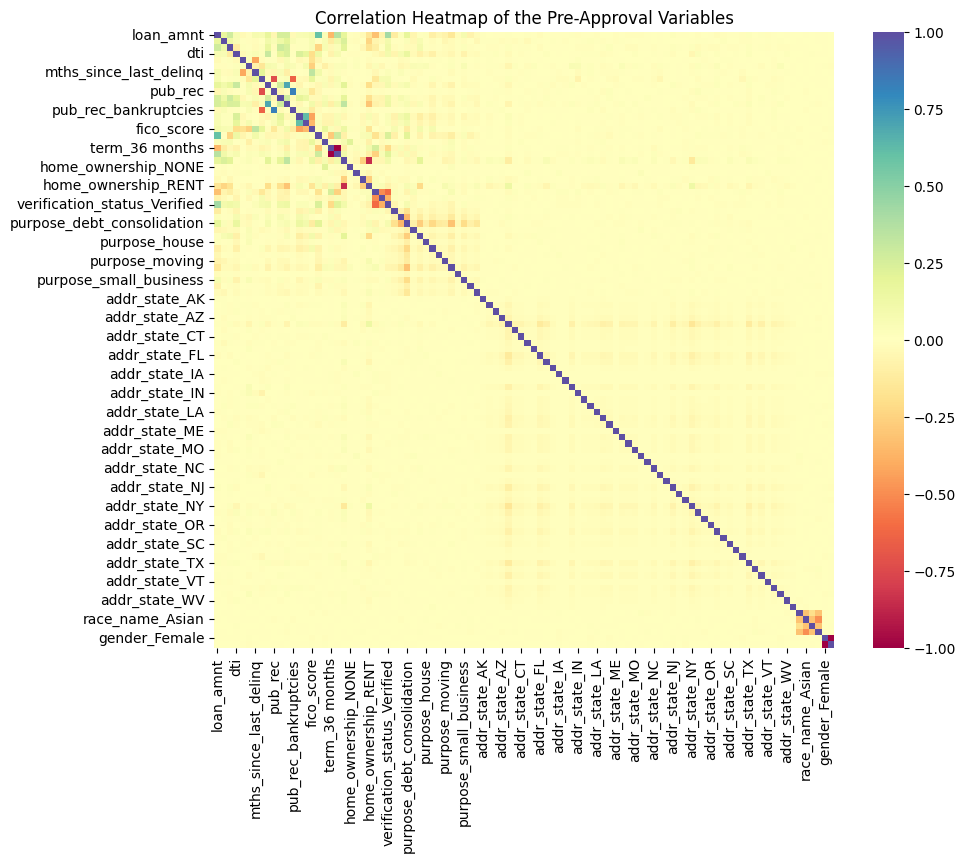

In [155]:
# Calculate the correlation matrix
correlation_matrix = df.drop(['id', 'member_id'], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='Spectral', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of the Pre-Approval Variables')
plt.show()

## Generating Synthetic Data:

In [156]:
test_output.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,...,pub_rec_bankruptcies,interest_rate,revol_utilization,number_bc_gt_75,fico_score,lti,month_since_oldest_tl,race_name,gender,
28054,774533,976716,2500,2500,2500.0,36 months,76.05,2.0,MORTGAGE,65000.0,...,0.0,0.0599,0.129,0,744,0.038462,198.0,White,Male,
28545,784938,988195,10000,10000,10000.0,36 months,304.18,0.0,RENT,33000.0,...,0.0,0.0599,0.008,0,799,0.303030,127.0,Asian,Female,
12,1000242,1225464,15000,15000,14975.0,60 months,389.36,10.0,MORTGAGE,86945.0,...,1.0,0.1903,0.729,1,699,0.172523,108.0,Asian,Male,
4132,219479,219422,7500,7500,4650.0,36 months,265.39,4.0,RENT,45000.0,...,0.0,0.1646,0.898,2,679,0.166667,137.0,African American,Male,
32175,855069,1067368,9200,9200,8925.0,60 months,209.29,2.0,RENT,31000.0,...,0.0,0.1299,0.099,0,724,0.296774,46.0,Other,Male,


In [157]:
smote = SMOTE()
x = df.drop(['id', 'member_id'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=26)

x_train, y_train = smote.fit_resample(x_train, y_train)

status_list = ['Approved' if x == 1 else 'Rejected' for x in y_test]
test_output['Actual Output'] = status_list

#### Logistic Regression

In [74]:
# scaling continuous variables
scaler = MinMaxScaler()
x[continuous_columns] = scaler.fit_transform(x[continuous_columns])

logistic_model = LogisticRegression(max_iter=50000)
logistic_model.fit(x_train, y_train)

C:\Users\unnat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=50000)

#### Performance Evaluation: Logistic Regression

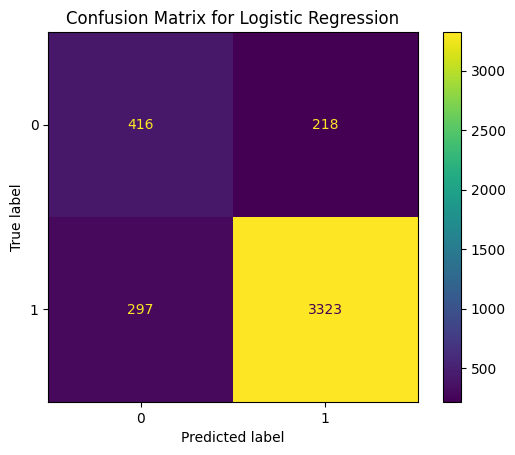

In [75]:
y_pred = logistic_model.predict(x_test)
y_pred2 = logistic_model.predict(x_train)

train_acc = accuracy_score(y_train, y_pred2)
accuracy = accuracy_score(y_test, y_pred)

status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['Logistic Regression Output'] = status_list

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

In [76]:
print(classification_report(y_true=y_train, y_pred=y_pred2))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     32488
           1       0.89      0.91      0.90     32488

    accuracy                           0.90     64976
   macro avg       0.90      0.90      0.90     64976
weighted avg       0.90      0.90      0.90     64976



In [77]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       634
           1       0.94      0.92      0.93      3620

    accuracy                           0.88      4254
   macro avg       0.76      0.79      0.77      4254
weighted avg       0.89      0.88      0.88      4254



#### Model: Decision Tree

In [78]:
x = df.drop(['id', 'member_id'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=26)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [79]:
# Define the hyperparameter grid
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=8,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)
# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print(f"Best cross-validation score: {random_search.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'splitter': 'best', 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 50, 'criterion': 'entropy'}
Best cross-validation score: 0.9390250683579676


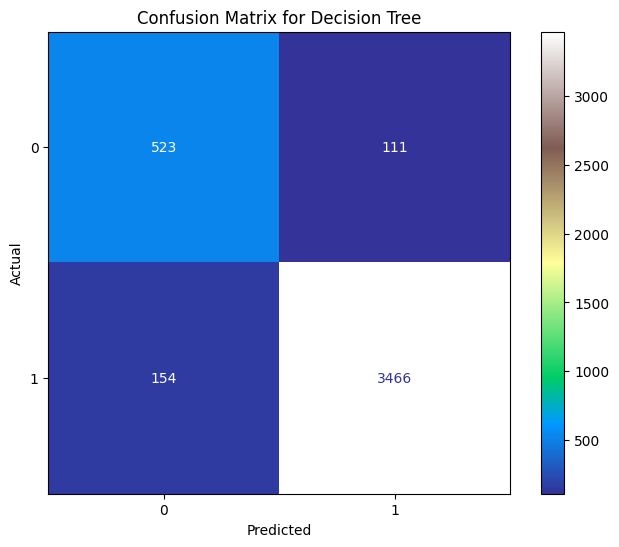

In [80]:
best_clf1 = random_search.best_estimator_

y_pred = best_clf1.predict(x_test)
y_pred2 = best_clf1.predict(x_train)

status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['Decision Tree Output'] = status_list

cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='terrain')  # You can change 'viridis' to any other colormap

# Customize plot titles and labels
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [81]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       634
           1       0.97      0.96      0.96      3620

    accuracy                           0.94      4254
   macro avg       0.87      0.89      0.88      4254
weighted avg       0.94      0.94      0.94      4254



In [82]:
print(classification_report(y_true=y_train, y_pred=y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32488
           1       0.97      0.97      0.97     32488

    accuracy                           0.97     64976
   macro avg       0.97      0.97      0.97     64976
weighted avg       0.97      0.97      0.97     64976



#### Model: Random Forest

In [83]:
# Step 5: Define the parameter grid
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Step 6: Set up the RandomizedSearchCV
rf_model2 = RandomForestClassifier(random_state=8)
random_search = RandomizedSearchCV(
    estimator=rf_model2,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,       # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Step 7: Fit the model
random_search.fit(x_train, y_train)

best_rf_model1 = random_search.best_estimator_
y_pred = best_rf_model1.predict(x_test)
y_pred_train = best_rf_model1.predict(x_train)

print(f"Best Parameters: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'bootstrap': True, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 62}


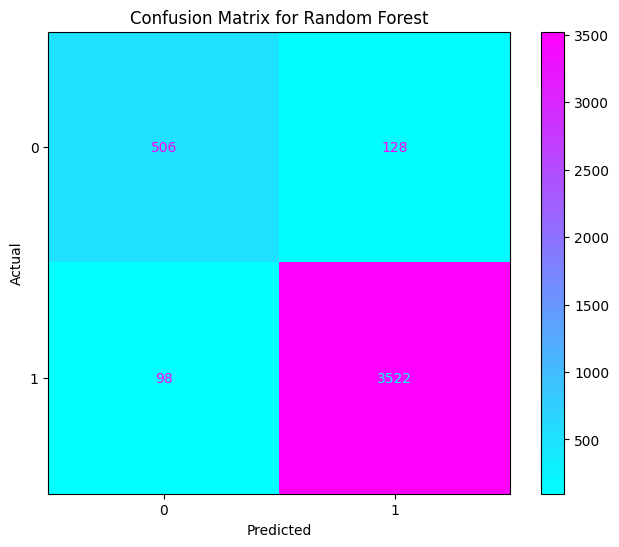

In [84]:
status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['Random Forest Output'] = status_list

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='cool') 

# Customize plot titles and labels
plt.title("Confusion Matrix for Random Forest")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [85]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       634
           1       0.96      0.97      0.97      3620

    accuracy                           0.95      4254
   macro avg       0.90      0.89      0.89      4254
weighted avg       0.95      0.95      0.95      4254



In [86]:
print(classification_report(y_true=y_train, y_pred=y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     32488
           1       0.97      0.98      0.97     32488

    accuracy                           0.97     64976
   macro avg       0.97      0.97      0.97     64976
weighted avg       0.97      0.97      0.97     64976



#### XGBoost

In [87]:
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

# Step 6: Set up the RandomizedSearchCV
xgb_model = XGBClassifier(random_state=101, use_label_encoder=False, eval_metric='logloss')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,       # 5-fold cross-validation
    verbose=2,
    random_state=101,
    n_jobs=-1   # Use all available cores
)

# Step 7: Fit the model
random_search.fit(x_train, y_train)

# Step 8: Evaluate the best model
best_xgb_model1 = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'colsample_bytree': 0.8200266907824011, 'gamma': 0.07386298095654742, 'learning_rate': 0.010292626061772505, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 129, 'subsample': 0.6925975190008589}


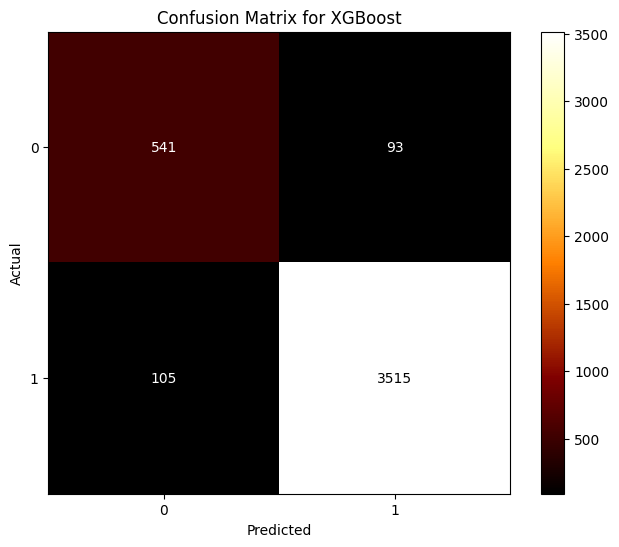

In [88]:
y_pred_train = best_xgb_model1.predict(x_train)
y_pred = best_xgb_model1.predict(x_test)

status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['XGBoost Output'] = status_list

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='afmhot') 

# Customize plot titles and labels
plt.title("Confusion Matrix for XGBoost")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [89]:
print("Classification Report for test set:")
print(classification_report(y_true=y_test, y_pred=y_pred))
print("\nClassification Report for train set:")
print(classification_report(y_true=y_train, y_pred=y_pred_train))

Classification Report for test set:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       634
           1       0.97      0.97      0.97      3620

    accuracy                           0.95      4254
   macro avg       0.91      0.91      0.91      4254
weighted avg       0.95      0.95      0.95      4254


Classification Report for train set:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     32488
           1       0.96      0.98      0.97     32488

    accuracy                           0.97     64976
   macro avg       0.97      0.97      0.97     64976
weighted avg       0.97      0.97      0.97     64976



#### Ensemble Model

In [90]:
from sklearn.ensemble import StackingClassifier

In [91]:
estimators = [
    ('dt', best_clf1),
    ('rf', best_rf_model1),
    ('xgb', best_xgb_model1),
]

# Define the meta-learner
meta_learner = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner
)

stacking_clf.fit(x_train, y_train)

y_pred = stacking_clf.predict(x_test)
y_pred_train = stacking_clf.predict(x_train)

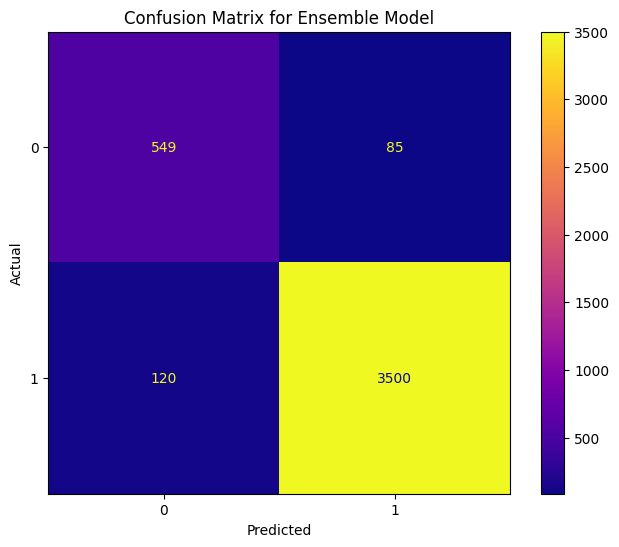

In [92]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='plasma') 

# Customize plot titles and labels
plt.title("Confusion Matrix for Ensemble Model")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [93]:
print(classification_report(y_true=y_train, y_pred=y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     32488
           1       0.98      0.97      0.98     32488

    accuracy                           0.98     64976
   macro avg       0.98      0.98      0.98     64976
weighted avg       0.98      0.98      0.98     64976



In [94]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       634
           1       0.98      0.97      0.97      3620

    accuracy                           0.95      4254
   macro avg       0.90      0.92      0.91      4254
weighted avg       0.95      0.95      0.95      4254



In [95]:
status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['Ensemble Model Output'] = status_list

In [96]:
with pd.ExcelWriter('Output.xlsx', mode='a', engine='openpyxl') as writer:
    test_output.to_excel(writer, sheet_name='Predictions with output columns removed', index=False)

C:\Users\unnat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Modelling after Removing the Sensitive Variables:

In [158]:
# test_output = test_output.drop(['Logistic Regression Output', 'Decision Tree Output', 'XGBoost Output', 'Ensemble Model Output'], axis=1)
# test_output = test_output.drop(['Random Forest Output'], axis=1)

test_output

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,...,interest_rate,revol_utilization,number_bc_gt_75,fico_score,lti,month_since_oldest_tl,race_name,gender,,Actual Output
28054,774533,976716,2500,2500,2500.00000,36 months,76.05,2.0,MORTGAGE,65000.0,...,0.0599,0.1290,0,744,0.038462,198.0,White,Male,,Approved
28545,784938,988195,10000,10000,10000.00000,36 months,304.18,0.0,RENT,33000.0,...,0.0599,0.0080,0,799,0.303030,127.0,Asian,Female,,Approved
12,1000242,1225464,15000,15000,14975.00000,60 months,389.36,10.0,MORTGAGE,86945.0,...,0.1903,0.7290,1,699,0.172523,108.0,Asian,Male,,Approved
4132,219479,219422,7500,7500,4650.00000,36 months,265.39,4.0,RENT,45000.0,...,0.1646,0.8980,2,679,0.166667,137.0,African American,Male,,Approved
32175,855069,1067368,9200,9200,8925.00000,60 months,209.29,2.0,RENT,31000.0,...,0.1299,0.0990,0,724,0.296774,46.0,Other,Male,,Approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8125,431130,511576,3000,3000,2950.00000,36 months,98.59,5.0,MORTGAGE,65200.0,...,0.1126,0.5810,1,704,0.046012,89.0,Asian,Male,,Approved
8267,433469,516370,18500,18500,18109.40272,36 months,622.22,3.0,RENT,145000.0,...,0.1287,0.5330,1,714,0.127586,134.0,Asian,Male,,Approved
26093,736534,933494,4000,4000,4000.00000,36 months,137.77,1.0,RENT,35000.0,...,0.1454,0.7690,1,704,0.114286,51.0,Other,Female,,Approved
126,1002568,1228613,25000,25000,24900.00000,60 months,564.87,5.0,MORTGAGE,184000.0,...,0.1269,0.1780,0,769,0.135870,126.0,White,Female,,Approved


In [159]:
df

,id,member_id,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,race_name_African American,race_name_Asian,race_name_Other,race_name_White,gender_Female,gender_Male
0,1000007,1225615,5150,1.0,34992.0,17.59,0.0,3.0,600.0,113.0,...,0,0,0,0,0,0,0,1,1,0
1,1000030,1225638,20000,6.0,72000.0,7.80,0.0,2.0,600.0,595.0,...,0,0,0,0,1,0,0,0,1,0
2,1000033,1225642,12800,9.0,81708.0,14.22,1.0,1.0,15.0,595.0,...,0,0,0,0,0,0,0,1,1,0
3,1000045,1225655,14000,9.0,72000.0,20.35,0.0,1.0,600.0,595.0,...,0,0,0,0,0,0,0,1,1,0
4,1000067,1225680,15000,0.0,72000.0,20.50,0.0,0.0,600.0,595.0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42530,999250,1224611,10000,3.0,30000.0,4.76,0.0,2.0,600.0,595.0,...,0,0,0,0,0,1,0,0,1,0
42531,999295,1224664,9600,5.0,45000.0,5.68,0.0,5.0,600.0,595.0,...,0,0,0,0,0,0,0,1,0,1
42532,999634,1225015,1200,3.0,20000.0,6.54,0.0,3.0,600.0,595.0,...,0,0,0,0,0,0,0,1,1,0
42533,999763,1225141,8000,4.0,38000.0,2.08,0.0,1.0,600.0,595.0,...,0,0,0,0,0,1,0,0,1,0


In [160]:
# Labels
y = output_columns['y']

# removing the sensitive variables from the DataFrame
word_to_filter = ('addr_state', 'gender', 'race_name')
columns_to_drop = [col for col in df.columns if col.startswith(word_to_filter)]
df = df.drop(columns=columns_to_drop)

df.head()

,id,member_id,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,1000007,1225615,5150,1.0,34992.0,17.59,0.0,3.0,600.0,113.0,...,0,0,0,0,0,0,0,0,0,0
1,1000030,1225638,20000,6.0,72000.0,7.80,0.0,2.0,600.0,595.0,...,0,0,0,0,1,0,0,0,0,0
2,1000033,1225642,12800,9.0,81708.0,14.22,1.0,1.0,15.0,595.0,...,1,0,0,0,0,0,0,0,0,0
3,1000045,1225655,14000,9.0,72000.0,20.35,0.0,1.0,600.0,595.0,...,0,0,0,0,0,0,0,0,0,0
4,1000067,1225680,15000,0.0,72000.0,20.50,0.0,0.0,600.0,595.0,...,0,0,0,0,0,0,0,1,0,0


In [104]:
# Segregaring Categorical and Continuous Columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns

continuous_columns = continuous_columns.to_list()
continuous_columns.remove('id')
continuous_columns.remove('member_id')

print(f"categorical: {categorical_columns}\ncontinuous: {continuous_columns}")

categorical: Index([], dtype='object')
continuous: ['loan_amnt', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'pub_rec_bankruptcies', 'revol_utilization', 'number_bc_gt_75', 'fico_score', 'lti', 'month_since_oldest_tl']


In [105]:
# One-Hot Encoding of categorical columns
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, one_hot_encoded.astype(int)], axis=1)

    df = df.drop(columns=[col])

df.head()

,id,member_id,loan_amnt,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,1000007,1225615,5150,1.0,34992.0,17.59,0.0,3.0,600.0,113.0,...,0,0,0,0,0,0,0,0,0,0
1,1000030,1225638,20000,6.0,72000.0,7.80,0.0,2.0,600.0,595.0,...,0,0,0,0,1,0,0,0,0,0
2,1000033,1225642,12800,9.0,81708.0,14.22,1.0,1.0,15.0,595.0,...,1,0,0,0,0,0,0,0,0,0
3,1000045,1225655,14000,9.0,72000.0,20.35,0.0,1.0,600.0,595.0,...,0,0,0,0,0,0,0,0,0,0
4,1000067,1225680,15000,0.0,72000.0,20.50,0.0,0.0,600.0,595.0,...,0,0,0,0,0,0,0,1,0,0


#### Logistic Regression

In [161]:
x = df.drop(['id', 'member_id'], axis=1)

# scaling continuous variables
scaler = MinMaxScaler()
x[continuous_columns] = scaler.fit_transform(x[continuous_columns])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=26)

smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)

LogisticRegression()

#### Performance Evaluation: Logistic Regression

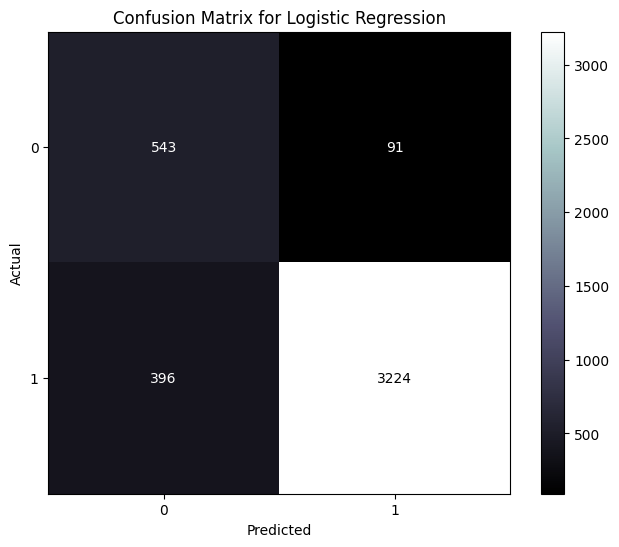

In [162]:
y_pred = logistic_model.predict(x_test)
y_pred2 = logistic_model.predict(x_train)

status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['Logistic Regression Output'] = status_list

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='bone') 

# Customize plot titles and labels
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [163]:
print(classification_report(y_true=y_train, y_pred=y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     32488
           1       0.89      0.88      0.88     32488

    accuracy                           0.88     64976
   macro avg       0.88      0.88      0.88     64976
weighted avg       0.88      0.88      0.88     64976



In [164]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.58      0.86      0.69       634
           1       0.97      0.89      0.93      3620

    accuracy                           0.89      4254
   macro avg       0.78      0.87      0.81      4254
weighted avg       0.91      0.89      0.89      4254



#### Model: Decision Tree

In [165]:
x = df.drop(['id', 'member_id'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=26)

smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

In [166]:
# Define the hyperparameter grid
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)
# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print(f"Best cross-validation score: {random_search.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 100, 'criterion': 'gini'}
Best cross-validation score: 0.9392250363594872


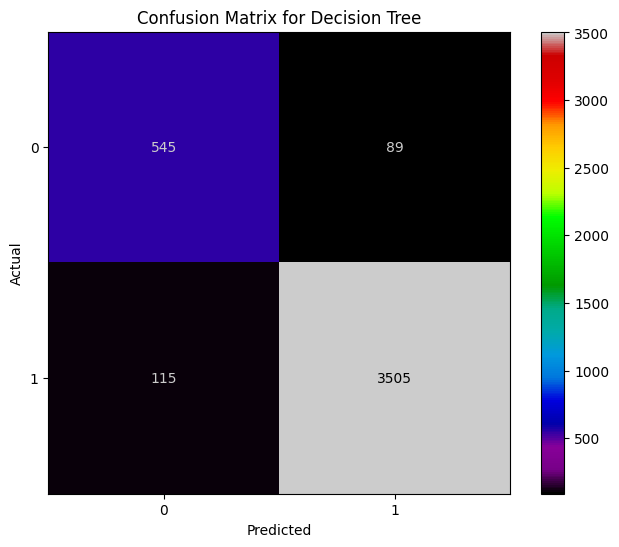

In [193]:
best_clf1 = random_search.best_estimator_

y_pred = best_clf1.predict(x_test)
y_pred2 = best_clf1.predict(x_train)

status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['Decision Tree Output'] = status_list

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='nipy_spectral') 

# Customize plot titles and labels
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [168]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       634
           1       0.97      0.95      0.96      3620

    accuracy                           0.94      4254
   macro avg       0.87      0.90      0.89      4254
weighted avg       0.94      0.94      0.94      4254



In [169]:
print(classification_report(y_true=y_train, y_pred=y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32488
           1       0.97      0.97      0.97     32488

    accuracy                           0.97     64976
   macro avg       0.97      0.97      0.97     64976
weighted avg       0.97      0.97      0.97     64976



#### Model: Random Forest

In [170]:
# Step 5: Define the parameter grid
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Step 6: Set up the RandomizedSearchCV
rf_model2 = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_model2,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,       # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Step 7: Fit the model
random_search.fit(x_train, y_train)

best_rf_model1 = random_search.best_estimator_
y_pred = best_rf_model1.predict(x_test)
y_pred_train = best_rf_model1.predict(x_train)

print(f"Best Parameters: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 13, 'n_estimators': 122}


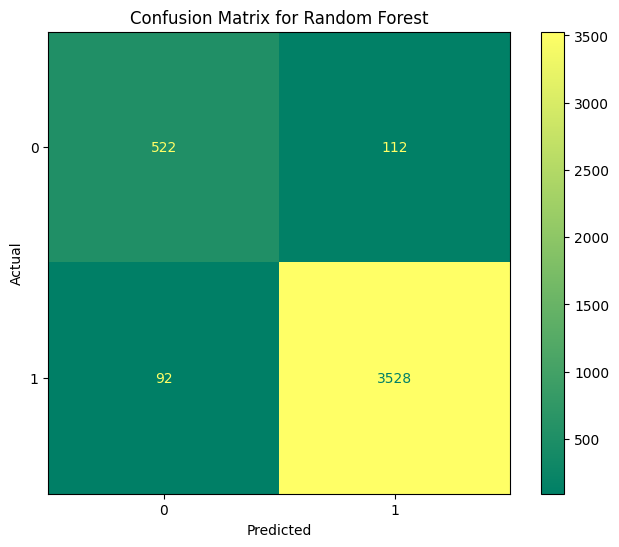

In [189]:
# status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
# test_output['Random Forest Output'] = status_list
y_pred = best_rf_model1.predict(x_test)
y_pred_train = best_rf_model1.predict(x_train)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='summer') 

# Customize plot titles and labels
plt.title("Confusion Matrix for Random Forest")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [172]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       634
           1       0.97      0.97      0.97      3620

    accuracy                           0.95      4254
   macro avg       0.91      0.90      0.90      4254
weighted avg       0.95      0.95      0.95      4254



In [173]:
print(classification_report(y_true=y_train, y_pred=y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     32488
           1       0.99      0.99      0.99     32488

    accuracy                           0.99     64976
   macro avg       0.99      0.99      0.99     64976
weighted avg       0.99      0.99      0.99     64976



#### XGBoost

In [174]:
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

# Step 6: Set up the RandomizedSearchCV
xgb_model = XGBClassifier(random_state=101, use_label_encoder=False, eval_metric='logloss')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,       # 5-fold cross-validation
    verbose=2,
    random_state=101,
    n_jobs=-1   # Use all available cores
)

# Step 7: Fit the model
random_search.fit(x_train, y_train)

# Step 8: Evaluate the best model
best_xgb_model1 = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'colsample_bytree': 0.8200266907824011, 'gamma': 0.07386298095654742, 'learning_rate': 0.010292626061772505, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 129, 'subsample': 0.6925975190008589}


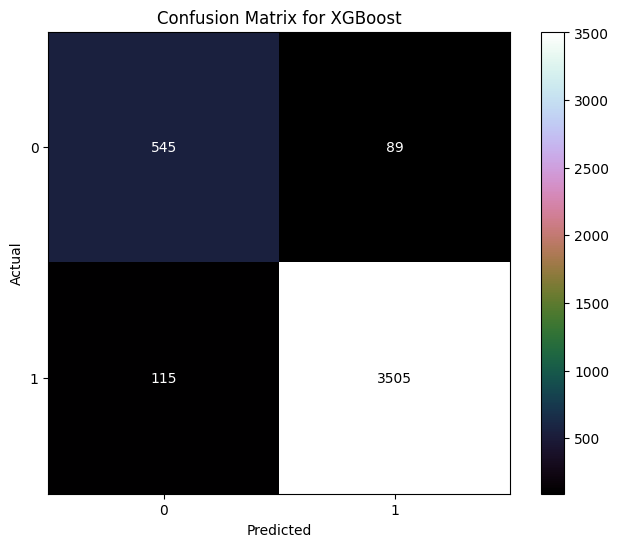

In [184]:
y_pred_train = best_xgb_model1.predict(x_train)
y_pred = best_xgb_model1.predict(x_test)

status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['XGBoost Output'] = status_list

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='cubehelix') 

# Customize plot titles and labels
plt.title("Confusion Matrix for XGBoost")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [186]:
print(classification_report(y_true=y_train, y_pred=y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     32488
           1       0.96      0.98      0.97     32488

    accuracy                           0.97     64976
   macro avg       0.97      0.97      0.97     64976
weighted avg       0.97      0.97      0.97     64976



In [187]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       634
           1       0.98      0.97      0.97      3620

    accuracy                           0.95      4254
   macro avg       0.90      0.91      0.91      4254
weighted avg       0.95      0.95      0.95      4254



#### Ensemble Model

In [176]:
from sklearn.ensemble import StackingClassifier

In [177]:
estimators = [
    ('dt1', best_clf1),
    ('rf1', best_rf_model1),
    ('xgb1', best_xgb_model1)
]

# Define the meta-learner
meta_learner = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner
)

stacking_clf.fit(x_train, y_train)

y_pred = stacking_clf.predict(x_test)
y_pred_train = stacking_clf.predict(x_train)

status_list = ['Approved' if x == 1 else 'Rejected' for x in y_pred]
test_output['Ensemble Model Output'] = status_list

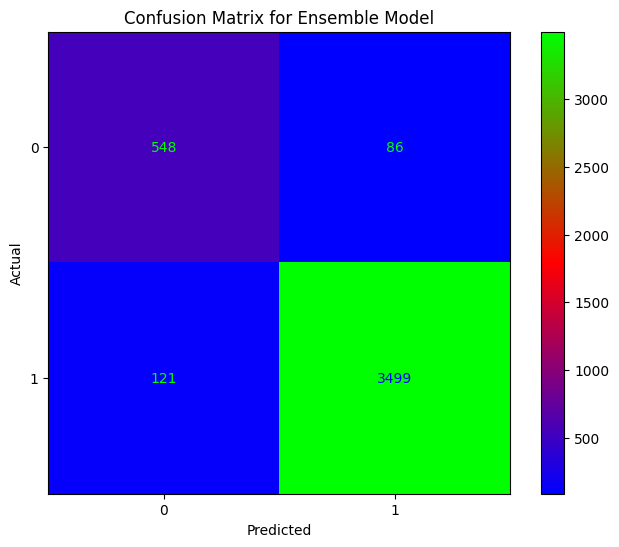

In [178]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='brg') 

# Customize plot titles and labels
plt.title("Confusion Matrix for Ensemble Model")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [179]:
print(classification_report(y_true=y_train, y_pred=y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     32488
           1       0.99      0.99      0.99     32488

    accuracy                           0.99     64976
   macro avg       0.99      0.99      0.99     64976
weighted avg       0.99      0.99      0.99     64976



In [180]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       634
           1       0.98      0.97      0.97      3620

    accuracy                           0.95      4254
   macro avg       0.90      0.92      0.91      4254
weighted avg       0.95      0.95      0.95      4254



In [181]:
with pd.ExcelWriter('Output.xlsx', mode='a', engine='openpyxl') as writer:
    test_output.to_excel(writer, sheet_name='Predictions on with output columns and sensitive fields removed', index=False)

C:\Users\unnat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


___________

In [182]:
import shap

100%|===================| 64927/64976 [09:54<00:00]        

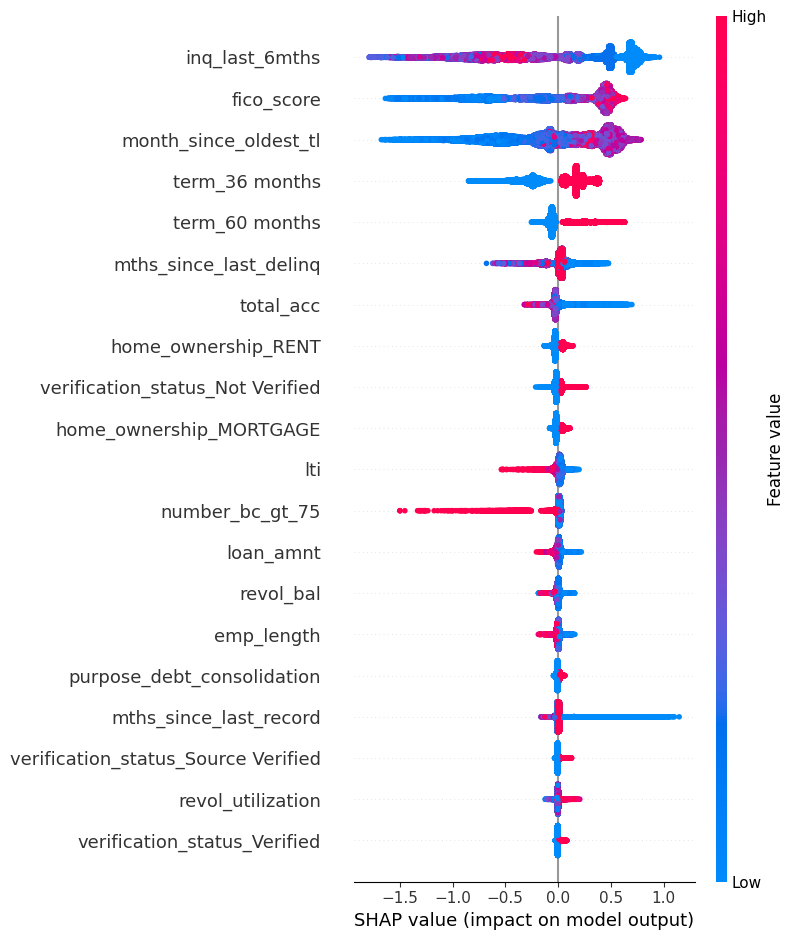

In [185]:
explainer = shap.Explainer(best_xgb_model1, x_train)

shap_res = explainer.shap_values(x_train)

In [ ]:
hap_values = explainer(x_train)

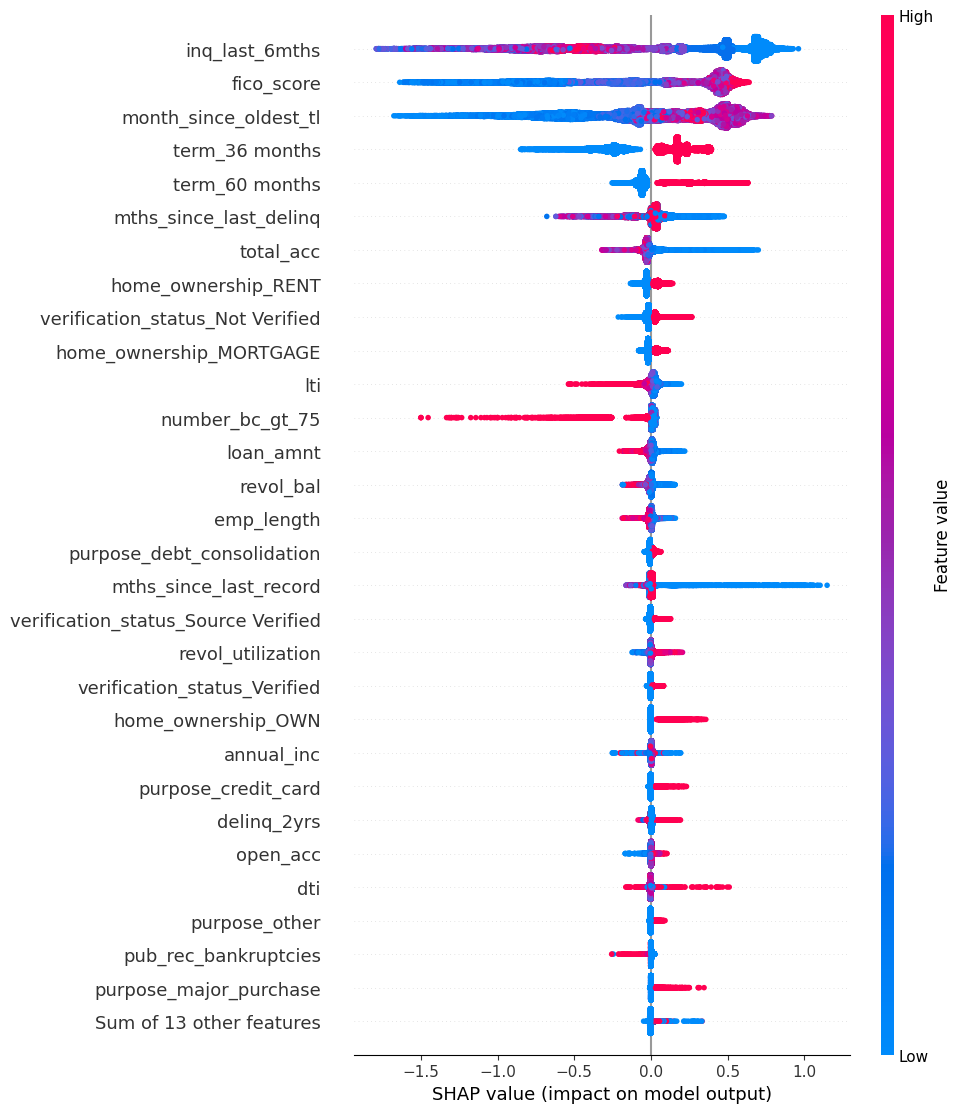

In [197]:
shap.plots.beeswarm(hap_values, max_display=30)

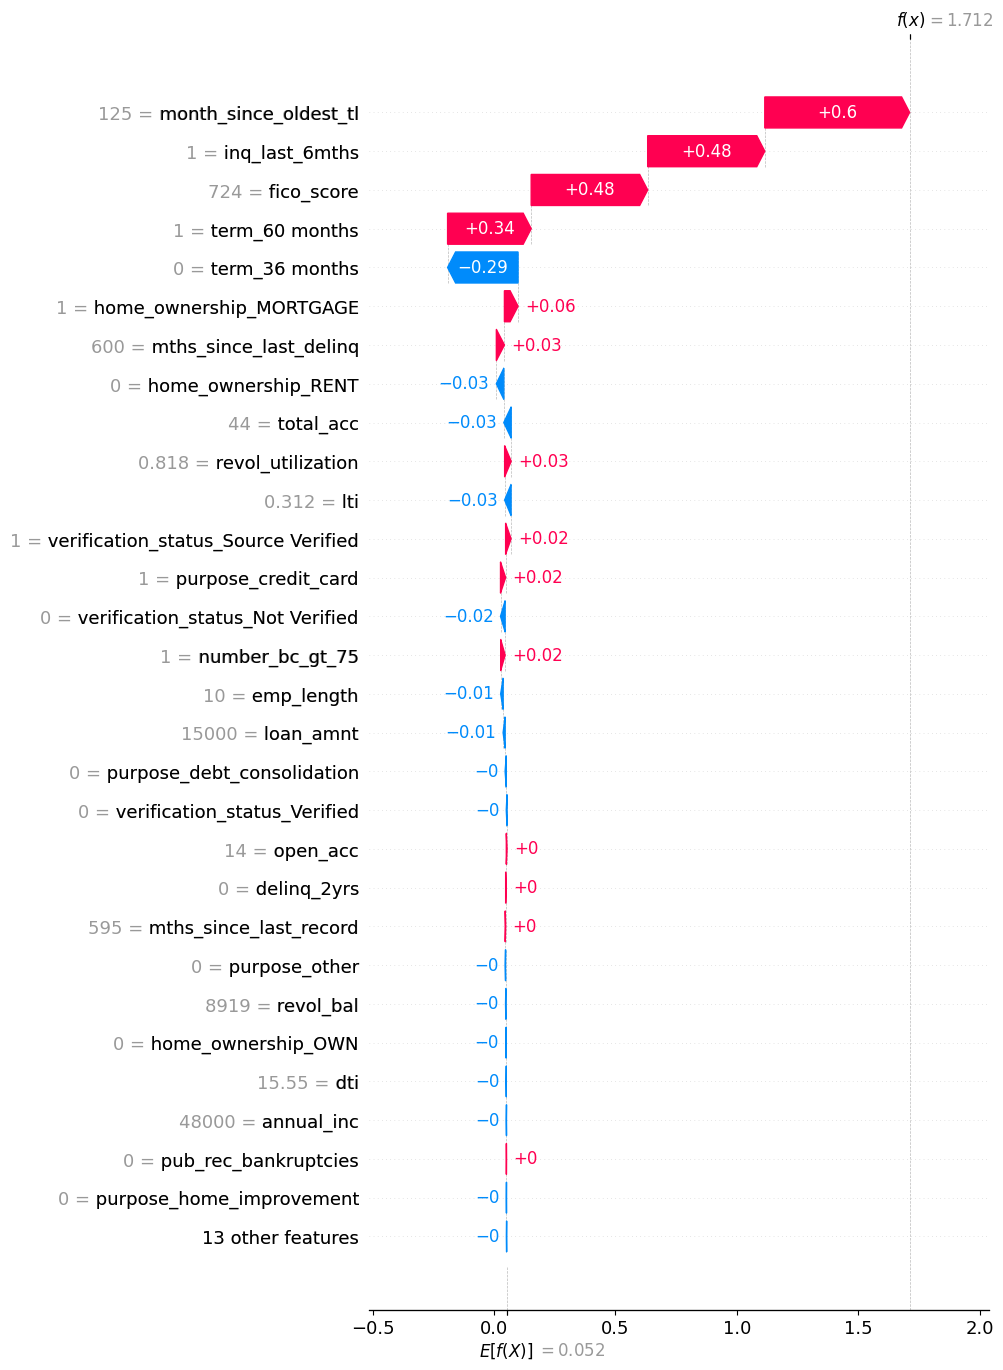

In [198]:
shap.plots.waterfall(hap_values[0], max_display=30)